## Neural  Networks


### 1.0 Loading and visualizing the data

The dataset for this task is a smaller version of MNIST (a database of handwritten digits) and contains 500 training samples and 200 test samples of handwritten digits collected from post-codes written on envelopes. Each sample is a
$28\times28$ pixels gray level image with an intensity that varies from 0 to 255, showing a single digit. For simplicity, each image is represented by a 784-dimensional vector. You can visualize the images as follows:

Number of train images: 500
Number of test images: 200
Image dim (flattened): 784
Label: 1


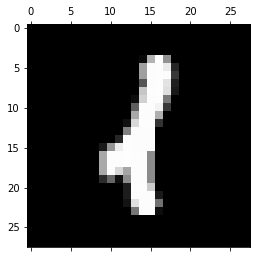

Label: 9


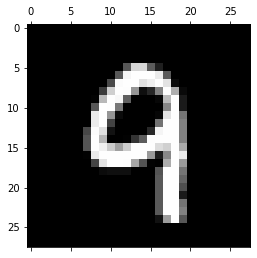

Label: 8


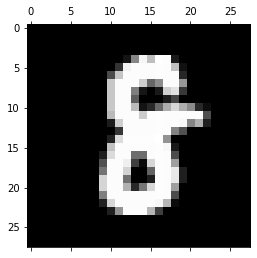

Label: 6


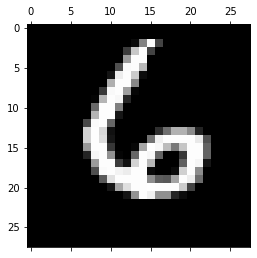

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

# train_set, test_set format: tuple(input, target)
# input is a numpy.ndarray of 2 dimensions (a matrix)
# where each row corresponds to an example.
# The target is a numpy.ndarray of 1 dimension (vector)
# that has the same length as the number of example images.

# Load the data
with open('./Data/mnist_sample.pkl', 'rb') as f:
    train_set, test_set = pickle.load(f, encoding='latin1')

# Divide in data and labels
x_train, y_train = train_set
x_test, y_test = test_set

# labels are given as integers, but we'll use one-hot encoding to represent them
y_train_1h = np.eye(10)[y_train]
y_test_1h = np.eye(10)[y_test]

# Print some info on the train and test set
print('Number of train images:', x_train.shape[0])
print('Number of test images:', x_test.shape[0])
print('Image dim (flattened):', x_train.shape[1])

for i in range(2):
    # plot the first examples in the training set
    print("Label:", y_train[i])
    plt.matshow(x_train[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.show()

    # plot the first examples in the test set
    print("Label:", y_test[i])
    plt.matshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray)
    plt.show()

### 1.1 One-layer feedforward networks and the delta rule

Now we proceed to create a one layer network with the following steps:

#### 1. Compute the output of the network (Forward pass):
Our task consists in a multi-class classification problem. A core ingredient of the neural network is the activation function of the output layer. In this case, the activation will be a softmax operator, which rescales a multidimensional vector to the range (0-1), and with its sum being equal to 1.

An example of how the softmax operation rescales a given vector:
<img src="./imgs/softmax.png" alt="softmax" style="width: 400px;"/>

This can be seen as a probability distribution of an input belonging to each of the $k$ classes:
<img src="./imgs/probability_distribution.png" alt="softmax" style="width: 400px;"/>

The formulation is as follows:

\begin{equation}
    \pmb{\hat{y}} = p_j = \frac{e^{o_j}}{\sum_k{e^{o_k}}}
\end{equation}

Where $p_j$ is the probability distribution of sample j  belonging to each class. Therefore $\sum p_j = 1$
And $o_j$ is the dot product of the weight matrix and the input:
\begin{equation}
o_j = \pmb{x} · W_{i,:} 
\end{equation}

Here we assume $x$ to be a vector with $l+1$ elements and matrix $W$ to have the dimensionality of $[(l+1)\times k]$. $p$ corresponds to the dimensionality of the input layer, in this case we defined it as a 784-dimensional vector (total amount of pixels in the image). The extra element ($+1$) in $x$ and $W$ correspond to the bias term.   

#### 2. Compute the loss function:

In order to evaluate the network performance a loss function is defined. The loss function indicates how good or bad is the network output with respect to the true label. Loss functions are chosen according to the problem at hand, in this case we will be using the cross-entropy (a.k.a. log-loss).

The cross-entropy loss for N samples and K classes is defined as follows:

$$L = -\frac{1}{N}\sum_{i=1}^N\sum_{k=1}^K t_{i,k} \log(\hat{y}_{i,k})$$

where *log* is the natural logarithm, $t_{i,k}$ is 1 if observation i is in class k and 0 otherwise, and $\hat{y}_{i,k}$ is the predicted probability that observation i is in class k. 

Notice that this function averages the loss according to a batch of N samples.

#### 3. Compute the gradient of the cross-entropy error wrt the softmax input: $∂o$

$$L = -\sum _{k} t_{i,k} \log(\hat{y}_{i,k})$$

$$\frac{∂L}{∂o_{i}} = -\sum _{k} t_{i,k} \frac{1}{p_k}\frac{∂p_k}{∂o_{i}} $$

and after some additional steps:

\begin{equation}
    \delta_o = \frac{∂L}{∂o} = \pmb{\hat{y}} − \pmb{y}
\end{equation} 

where:
$o = x · W $ (Bias component as part of x and W)

$\pmb{y}$ is the one-hot encoded target vector

<br><br>
#### 4. Compute the gradient of the error function with respect to the current weights at iteration $\tau$:
\begin{equation}
    \frac{∂L}{∂W^{\tau}} = \frac{∂L}{∂o} \frac{∂o}{∂W^{\tau}}= \pmb{x}^T · \delta_o
\end{equation} 

#### 5. Finally, update the weights at iteration $\tau$ using a stochastic gradient descent (SGD) update rule with a learning rate of $\eta$:
\begin{equation}
   W^{\tau +1} = W^{\tau} − η \frac{∂L}{∂W^{\tau}}
\end{equation}

### 1.2 



In [2]:
def softmax(x):
    resM = None
    for row in x:   
        e = np.exp(row)
        res = np.divide(e,np.sum(e))
        resM = res if resM is None else np.vstack((resM,res))
    return resM

# If you want, you can test if your function works correctly.
test_array = np.array([[0.101, 0.202, 0.303],
                       [0.404, 0.505, 0.606]])
test_output = [[0.30028906,  0.33220277,  0.36750817],
               [0.30028906,  0.33220277,  0.36750817]]

# This should equal to True
print(np.allclose(softmax(test_array), test_output))

True


Now we implement the cross-entropy loss following step 2 instructions:

To avoid numerical issues with logarithm,  we will clip the predictions to $[10^{-12}, 1-10^{-12}]$ range. This means every value outside the range will be clipped to the interval edges

In [3]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes stable cross entropy between predictions and targets
    :param predictions: Corresponds to the output vector of the neural net (n_observations, n_classes)
    :param targets: targets are the true labels encoded as one-hot vector (n_observations, n_classes)
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    L = np.sum(np.log(predictions)*targets)*(-1/predictions.shape[0])
    return L

# If you want, you can test if your function works correctly.
predictions = np.array([[0.25, 0.25, 0.25, 0.25],
                        [0.01, 0.01, 0.01, 0.96]])
targets = np.array([[0, 0, 0, 1],
                    [0, 0, 0, 1]])
ans = 0.71355817782
x = cross_entropy(predictions, targets)
if np.isclose(x, ans):
    print("Test passed.")
else:
    print("Test failed.")

Test passed.


In [4]:
############################# READ ONLY #############################

Now, define the function that updates the weights. Use previously defined functions as required

In [5]:
def update_weights(x, W, target, learning_rate):
    """
    Main routine to update weights.

    :param x: Input vector (1, n_features + 1)
    :param W: Weight matrix (n_features + 1, n_classes)
    :param target: The true label(s) encoded as one-hot vector (n_observations, n_classes)
    :param learning_rate: alpha parameter that determines the size of updates


    """

    # Output of the network. As explained in step 1.
    pred = None

    # compute gradient with respect to input (delta zero). As explained in step 3.
    d_o = None

    # compute gradient with respect of the weights. As explained in step 4.
    gradient = None

    # computer the new weights. As explained in step 5.
    new_W = None

    o = np.dot(x,W)
    pred = softmax(o)
    d_o = pred - target
    gradient = np.dot(x.T,d_o)
    new_W = W - learning_rate * gradient
    return(new_W)

In [6]:
############################# READ ONLY #############################

If the update_weights function has been properly defined the next loop will train the Neural network with 5000 steps and a learning rate of 0.01

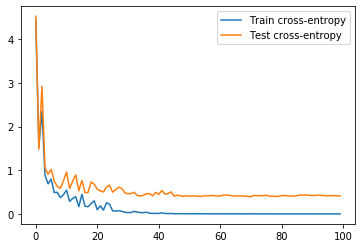

Train CE 0.004206257361017234
Train accuracy 1.0
Test CE 0.40696767987511595
Test accuracy 0.895


In [7]:
rng = np.random.RandomState(82)  # set seed for the random number generator
x_dim = x_train.shape[1]  # number of pixels in the image
n_train = x_train.shape[0]  # number of training examples
n_test = x_test.shape[0]  # number of test examples
n_classes = 10  # number of classes

# create an initial weigth matrix with dimensions (n_classes, x_dim + 1)
# 1 is added to x_dim to account for the bias
W = rng.normal(size=(x_dim + 1, n_classes)) * 0.001

n_iter = 10000  # number of training iterations
learning_rate = 0.1  # learning rate

ce_train = []
ce_test = []

for iter in range(n_iter):
    i = rng.randint(n_train)  # random index for an image
    x = np.append(x_train[i], 1)[None, :]  # appends 1 for bias
    target = y_train_1h[i][None, :]  # 1-hot encoded target vector

    # update weights using the previously defined function
    new_W = update_weights(x, W, target, learning_rate)
    W = new_W

    # compute CE on the full training set every 100 iterations
    if iter % 100 == 0:
        # compute CE for every training sample
        x = np.concatenate((x_train, np.ones((n_train, 1))), axis=1)
        x_pred = softmax(np.dot(x, W))
        ce_train.append(cross_entropy(x_pred, y_train_1h))

        x = np.concatenate((x_test, np.ones((n_test, 1))), axis=1)
        x_pred = softmax(np.dot(x, W))
        ce_test.append(cross_entropy(x_pred, y_test_1h))


plt.plot(np.arange(n_iter/100), ce_train, label='Train cross-entropy')
plt.plot(np.arange(n_iter/100), ce_test, label='Test cross-entropy')
plt.legend()
plt.show()

# train error after training the NN
x = np.concatenate((x_train, np.ones((n_train, 1))), axis=1)
x_pred = softmax(np.dot(x, W))
x_pred_max = np.argmax(x_pred, axis=1)
ans_ce_train = cross_entropy(x_pred, y_train_1h)
ans_acc_train = 1. * np.equal(x_pred_max, y_train).sum() / n_train
print('Train CE', ans_ce_train)
print('Train accuracy', ans_acc_train)

# test error after training the NN
x = np.concatenate((x_test, np.ones((n_test, 1))), axis=1)
x_pred = softmax(np.dot(x, W))
x_pred_max = np.argmax(x_pred, axis=1)
ans_ce_test = cross_entropy(x_pred, y_test_1h)
ans_acc_test = 1. * np.equal(x_pred_max, y_test).sum() / n_test
print('Test CE', ans_ce_test)
print('Test accuracy',  ans_acc_test)

### 1.3 Tuning a Neural Network

In this section we will show examples and discuss the tuning process of the network. 
**Important: you require to have the update_weights function properly defined.**

Try to experiment with different values for the learning rate, e.g. $η = \{0.000001, 0.001, 0.01, 0.02, 0.7\}$, as well with different amount of iterations.

- What are the lowest train and test errors you get? 

- What happens to the training curve when using different learning rates? When it is small? and when it is large?

- Gradient based algorithms are scale-sensible algorithm, meaning that the magnitude of the variables affects its performance. When using gradient-based learning, it is recommended to scale the input data so the features are in [0, 1] or [-1, +1] range, or such that they have 0 mean and unit variance. In most cases it improves convergence.

- Inspect the training error and testing error plots. What do you notice? What is the relation between the training and testing errors?

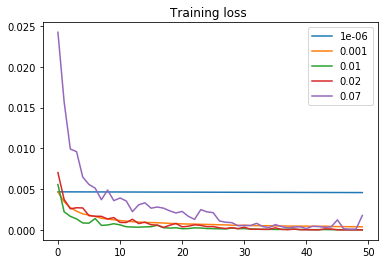

Maximum accuracy on test (0.845 %) with learning rate 0.01


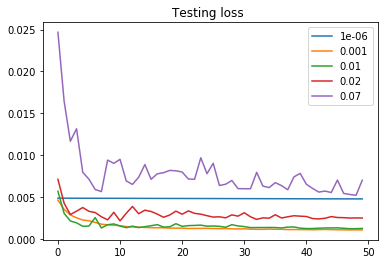

Maximum accuracy on test (0.845 %) with learning rate 0.01


In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
x_train_copy = x_train.copy()
x_test_copy = x_test.copy()
storing_step = 100  # Variable for plotting/storing purposes.

#------------------------------------------------------------------------------------#
# We use the scaler functions from Sklearn to transform the training and testing data
#------------------------------------------------------------------------------------#

standard_scaler = StandardScaler(with_mean=0, with_std=1)
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))

#x_train_copy = minmax_scaler.fit_transform(x_train_copy)
#x_test_copy = minmax_scaler.transform(x_test_copy)

# You can also try the standard scaler

x_train_copy = standard_scaler.fit_transform(x_train_copy)
x_test_copy = standard_scaler.transform(x_test_copy)

#------------------------------------------------------------------------------------#
# Number of iterations                                                               #
#------------------------------------------------------------------------------------#
n_iter = 5000

#------------------------------------------------------------------------------------#
# Learning rates                                                                     #
#------------------------------------------------------------------------------------#
learning_rates = [0.000001, 0.001, 0.01, 0.02, 0.07]


# Dictionary to store information while training
stats = {'ce_loss_train': np.zeros([len(learning_rates), n_iter//storing_step]),
         'ce_loss_test': np.zeros([len(learning_rates), n_iter//storing_step]),
         'train_loss': np.zeros(len(learning_rates)),
         'train_acc': np.zeros(len(learning_rates)),
         'test_loss': np.zeros(len(learning_rates)),
         'test_acc': np.zeros(len(learning_rates))}

for e, learning_rate in enumerate(learning_rates):
    k = 0
    W = rng.normal(size=(x_dim + 1, n_classes)) * 0.01

    # TRAINING
    for iter in range(n_iter):
        i = rng.randint(n_train)  # random index for an image
        x = np.append(x_train_copy[i], 1)[None, :]  # appends 1 for bias
        target = y_train_1h[i][None, :]       # 1-hot encoded target vector

        # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
        # Update weights using the previously defined function  #
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

        new_W = update_weights(x, W, target, learning_rate)

        # ! UPDATE WEIGHTS
        W = new_W

        # compute CE on the full training set every 100 iterations
        if iter % storing_step == 0:
            # compute CE for every training sample
            x = np.concatenate((x_train_copy, np.ones((n_train, 1))), axis=1)
            x_pred = softmax(np.dot(x, W))
            #x_pred_max = np.argmax(x_pred,axis=1)
            stats['ce_loss_train'][e][k] = cross_entropy(
                x_pred, y_train_1h)/n_train

            x = np.concatenate((x_test_copy, np.ones((n_test, 1))), axis=1)
            x_pred = softmax(np.dot(x, W))
            #x_pred_max = np.argmax(x_pred,axis=1)
            stats['ce_loss_test'][e][k] = cross_entropy(
                x_pred, y_test_1h)/n_train

            k += 1

    # final train error
    x = np.concatenate((x_train_copy, np.ones((n_train, 1))), axis=1)
    x_pred = softmax(np.dot(x, W))
    x_pred_max = np.argmax(x_pred, axis=1)

    stats['train_loss'][e] = cross_entropy(x_pred, y_train_1h) / n_train
    stats['train_acc'][e] = 1. * np.equal(x_pred_max, y_train).sum() / n_train

    x = np.concatenate((x_test_copy, np.ones((n_test, 1))), axis=1)
    x_pred = softmax(np.dot(x, W))
    x_pred_max = np.argmax(x_pred, axis=1)

    stats['test_loss'][e] = cross_entropy(x_pred, y_test_1h) / n_test
    stats['test_acc'][e] = 1. * np.equal(x_pred_max, y_test).sum() / n_test

plt.plot(stats['ce_loss_train'].T)
plt.legend([str(s) for s in learning_rates])
plt.title("Training loss ")
plt.show()
max_ix = np.argmax(stats["train_acc"])
print("Maximum accuracy on test ({} %) with learning rate {}".format(
    stats["test_acc"][max_ix], learning_rates[max_ix]))

plt.plot(stats['ce_loss_test'].T)
plt.legend([str(s) for s in learning_rates])
plt.title("Testing loss ")
plt.show()

max_ix = np.argmax(stats["test_acc"])
print("Maximum accuracy on test ({} %) with learning rate {}".format(
    stats["test_acc"][max_ix], learning_rates[max_ix]))

### 1.4 Visualizing the weights

Now we will train the network longer, e.g. for 10000 iterations with  $η = 0.01$ and visualize the weights.
We do this per row, but exclude the last column, which includes the bias weight (reshape the resulting vector to $28 \times 28$ as we did with images). Do you observe something peculiar? Do you know why it happens?

In [9]:
learning_rate = 0.01
n_iter = 10000
k = 0

W = rng.normal(size=(x_dim + 1, n_classes)) * 0.01

bkp_rate = 1000

stats = {"backup_weights": np.zeros([n_iter//bkp_rate, x_dim, n_classes])}
for iter in range(n_iter):
    i = rng.randint(n_train)  # random index for an image
    x = np.append(x_train[i], 1)[None, :]  # appends 1 for bias
    target = y_train_1h[i][None, :]       # 1-hot encoded target vector

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Update weights using the previously defined function  #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    new_W = update_weights(x, W, target, learning_rate)
    W = new_W

    # compute CE on the full training set every bkp_rate iterations
    if iter % bkp_rate == 0:
        stats["backup_weights"][k] = W[:-1, :].reshape(x_dim, n_classes)
        k += 1

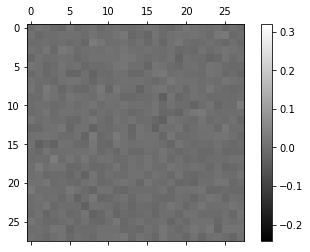

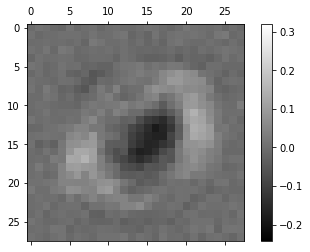

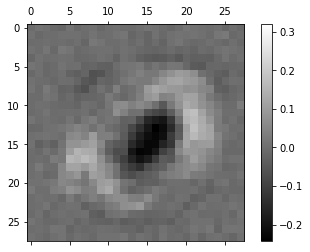

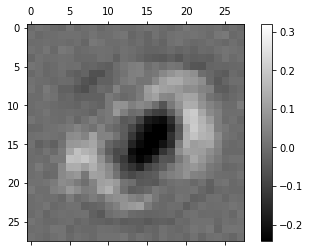

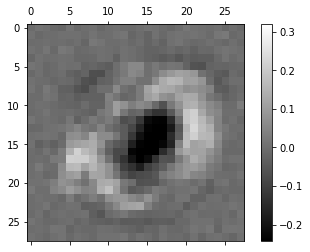

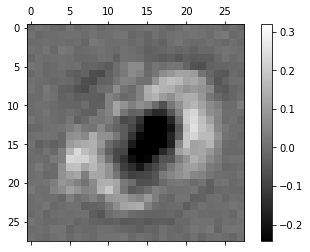

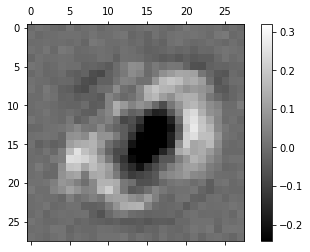

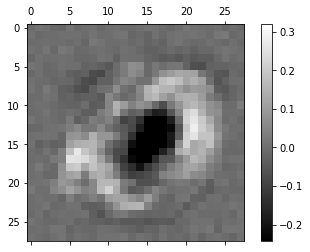

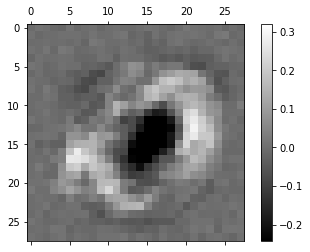

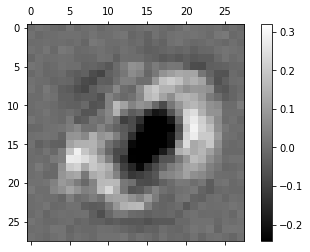

In [10]:
# Choose a number between 0 and 9.
vmin, vmax = stats["backup_weights"].min(), stats["backup_weights"].max()

pick_number = 0
for i in range((n_iter//bkp_rate)):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    cax = ax.matshow(stats["backup_weights"][i][:, pick_number].reshape(
        28, 28), cmap=plt.cm.gray, vmin=.5 * vmin, vmax=.5 * vmax)
    fig.colorbar(cax)

    plt.show()

### 2.1 Two-layer feedforward networks and the backpropagation algorithm

Using backpropagation, we will need to optimize two weight matrices $W_1$ and $W_2$, and bias weights $b_1$ and $b_2$, which we will now consider separately. 
Further, we assume that an input matrix $x$ has a shape of $[n\_examples \times n\_dimensions]$. Weights $W$ have a shape $[number\_of\_input\_units \times number\_of\_output\_units]$. 

![title](./imgs/nn.png)

#### A forward pass through the network:

  $z_1 = x · W_1 + b_1$ 
  
  $A_1 = f(z_1)$, where $f = tanh$
  
  $z_2 = A_1W_2 + b_2$
  
  $y = softmax(z_2)$


#### A backward pass:

$\frac{∂L}{∂z_2} = \delta_o = y − t$ 

$\frac{∂L}{∂W_2} = A_1^T · \delta_o$

$\frac{∂L}{∂z_1} = \delta_h = \delta_o · W_2^T  \times \frac{∂A_1}{∂z_1},$   where $\times$ denotes elementwise multiplication

$\frac{∂L}{∂W_1} =  X^T · \delta_h$

## Part 2

Train a two-layer feedforward network with the backpropagation algorithm. Your algorithm needs to learn the optimal parameters for 4 sets of weight matrices, $W_{in}$, $b_{in}$, $W_{out}$ and $b_{out}$. You need to fill the missing code below, the formulas for the gradients of the bias ($\frac{∂L}{∂b_{in}}$ and $\frac{∂L}{∂b_{out}}$ are already defined).

As activation function we will use *tanh* for the hidden layer.

#### Notes 

* First of all, complete the *forward_step* function, which evaluates the forward pass through the network. 

* Remember that $\frac{∂tanh(x)}{∂x} = 1 - tanh^2(x)$

* If everything is correct, the results after 200 iteration should be:

`Train CE 0.036090180542620795
Train accuracy 1.0
Test CE 0.32940399267011444
Test accuracy 0.88`

In [11]:
def forward_pass(x, W1, b1, W2, b2, return_output_only=False):
    """
    Forward pass routine, which consists of the activation of two layers.

    :param x: Input matrix (n_samples, n_features)
    :param W1: Weight matrix of first activation layer (n_features, n_hidden_units W2)
    :param b1: bias vector of first layer (1, n_hidden_units W2)
    :param W2: Weight matrix of second activation layer (n_hidden_units W2, n_classes)
    :param b2: bias vector of second layer (1, n_classes)

    :param return_output_only: Boolean to decide whether to return only the output vector or also intermediate steps.    
    """

    z1 = None
    a1 = None
    z2 = None
    y = None

    z1 = np.dot(x,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    y = softmax(z2)

    if return_output_only:
        return y

    return z1, a1, z2, y

In [12]:
############################# READ ONLY #############################

In [13]:
def backward_pass(predictions, targets, a1, W2, X):
    """
    Backward pass routine, which consists of the gradient propagation of two layers.

    :param predictions: Output matrix of the forward pass (n_samples, n_classes)
    :param targets: The correct labels one-hot encoded (n_samples, n_classes)
    :param a1: Activation output of first layer (n_smaples, n_hidden_units W2)
    :param W2: Weight matrix of second activation layer (n_hidden_units W2, n_classes)
    :param X: Input matrix of the forward pass(n_samples, n_features)

    :param return_output_only: Boolean to decide whether to return only the output vector or also intermediate steps.    
    """

    delta_out = predictions - targets
    dW2 = np.dot(a1.T,delta_out)
    db2 = np.sum(delta_out, axis=0, keepdims=True)  # already correct
    delta_h = np.multiply(np.dot(delta_out,W2.T),1-np.square(a1))
    dW1 = np.dot(X.T,delta_h)
    db1 = np.sum(delta_h, axis=0)  # already correct
    

    return dW1, db1, dW2, db2

In [14]:
############################# READ ONLY #############################

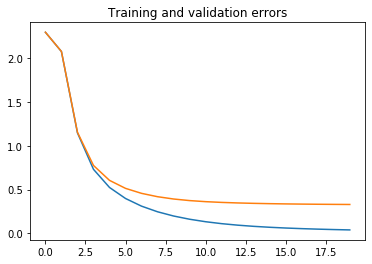

Train CE 0.03609018054262079
Train accuracy 1.0
Test CE 0.32940399267011444
Test accuracy 0.88


In [15]:
rng = np.random.RandomState(100)  # set seed for the random number generator
n_iter = 200  # number of training iterations
learning_rate = 0.001
n_hidden = 50

W1 = rng.randn(x_dim, n_hidden) * 0.01
b1 = np.zeros((1, n_hidden))
W2 = rng.randn(n_hidden, n_classes) * 0.0
b2 = np.zeros((1, n_classes))

ce_train = []
ce_test = []

for iter in range(n_iter):

    z1, a1, z2, y = forward_pass(x_train, W1, b1, W2, b2)
    dW1, db1, dW2, db2 = backward_pass(y, y_train_1h, a1, W2, x_train)

    # update parameters
    W1 += -learning_rate * dW1
    b1 += -learning_rate * db1
    W2 += -learning_rate * dW2
    b2 += -learning_rate * db2

    if iter % 10 == 0:
        x_pred = forward_pass(x_train, W1, b1, W2, b2, return_output_only=True)
        ce_train.append(cross_entropy(x_pred, y_train_1h))

        x_pred = forward_pass(x_test, W1, b1, W2, b2, return_output_only=True)
        ce_test.append(cross_entropy(x_pred, y_test_1h))

plt.plot(ce_train)
plt.plot(ce_test)
plt.title("Training and validation errors")
plt.show()

# final train error
x_pred = forward_pass(x_train, W1, b1, W2, b2, return_output_only=True)
x_pred_max = np.argmax(x_pred, axis=1)
ans_ce_train = cross_entropy(x_pred, y_train_1h)
ans_acc_train = 1. * np.equal(x_pred_max, y_train).sum() / n_train
print('Train CE', ans_ce_train)
print('Train accuracy', ans_acc_train)

# final test error
x_pred = forward_pass(x_test, W1, b1, W2, b2, return_output_only=True)
x_pred_max = np.argmax(x_pred, axis=1)
ans_ce_test = cross_entropy(x_pred, y_test_1h)
ans_acc_test = 1. * np.equal(x_pred_max, y_test).sum() / n_test
print('Test CE', ans_ce_test)
print('Test accuracy',  ans_acc_test)

### 3. Conclusion 
The performance of our simple neural network can be easily improved in many ways, e.g.
1. Better initialization of the weights.
2. Fine-tuning the batch size.
3. Normalize the input.
4. More sophisticated optimization methods (with momentum, adaptive learning rates, etc.).
5. Data augmentation.

## Using toolboxes - extra information 

### SciKit Learn

The popular machine learning toolbox scikit-learn provides an implementation of a standard MLP. A detailed tutorial on how to use Multi-layer Perceptron in scikit-learn can be found [here](http://scikit-learn.org/stable/modules/neural_networks_supervised.html). Below we outlined how to use scikit-learn on MNIST. Feel free to modify the default parameters of the model (read [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)) and try to use different scaling schemes for the input data.

In [16]:
import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

clf = MLPClassifier(hidden_layer_sizes=(50,))
clf.fit(x_train, y_train_1h)

x_pred = clf.predict(x_train)
x_pred_max = np.argmax(x_pred, axis=1)
print('Train CE', log_loss(y_train, x_pred))
print('Train accuracy',  accuracy_score(y_train, x_pred_max))

x_pred = clf.predict(x_test)
x_pred_max = np.argmax(x_pred, axis=1)
print('Test CE', log_loss(y_test, x_pred))
print('Test accuracy',  accuracy_score(y_test, x_pred_max))

Train CE 9.192646643896338e-15
Train accuracy 1.0
Test CE 2.80234092428023
Test accuracy 0.765


C:\Users\Luca\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Keras
Another popular framework for Neural Networks. It is an API that works on top of Tensorflow, CNTK or Theano and that contains the most common models for small projects. We could see it as an intermediate step between Sciki-Learn and the DL libraries (next section).

- Keras Documentation [here](https://keras.io)

### TensorFlow

When you require more freedom over your model's architecture and/or training, you should resort to more sophisticated toolkits, like [TensorFlow](https://www.tensorflow.org/).
In broad terms TensorFlow allows performing computations in a data graph which offers several advantages:
- High modularity, which facilitates parallel operations.
- Automatic differentiation, ideal to calculate gradients.
- Fine control of pretty much everything. 

Following a code example that solves the same classification problem. We can appreciate that we can define the number of hidden units in each layer, the batch size for training, as well as the activation function for each layer.

In [17]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 50  # Train sample by sample

display_step = 30

# Network Parameters
n_hidden_1 = 50  # 1st hidden layer
n_hidden_2 = 50  # 2nd hidden layer
num_input = 784  # MNIST data input (img shape: 28*28)
num_classes = 10  # MNIST total classes (0-9 digits)


# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Define model


def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer


# Construct model
logits = neural_net(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

# List of optimziers
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables
init = tf.global_variables_initializer()

# Start training
stats = {'loss': np.zeros(1+(num_steps)//display_step),
         'acc': np.zeros(1+(num_steps)//display_step)}
k = 0
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        rand_index = np.random.choice(len(x_train), size=batch_size)

        batch_x, batch_y = x_train[rand_index], y_train_1h[rand_index]

        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            stats['loss'][k] = loss
            stats['acc'][k] = acc
            k += 1
            print("Step " + str(step) + ", Minibatch Loss= " +
                  "{:.4f}".format(loss) + ", Training Accuracy= " +
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:",
          sess.run(accuracy, feed_dict={X: x_test,
                                        Y: y_test_1h}))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
plt.plot(stats['loss'])
plt.title("Loss-Cross Entropy")
plt.show()

plt.plot(stats['acc'])
plt.title("Accuracy")
plt.show()

Final remark. Tensorflow is only one of the many Deep learning libraries available. Although it may be one of the most used libraries, there are plenty of other options. (You can easily find more information about their differences elsewhere).

- Torch [For Lua](https://torch.ch/) [For Python](https://pytorch.org/)
- Caffe [here](https://caffe.berkeleyvision.org/) / Caffe2 [here](https://caffe2.ai/)
- CNTK [Github](https://github.com/Microsoft/CNTK)

Some extra links:
- Stanford course on Tensorflow https://web.stanford.edu/class/cs20si/
- A nice visual tool for Neural Networks: http://playground.tensorflow.org